In [1]:
import xgboost as xgb
import catboost as cat
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedGroupKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

In [2]:
KAGGLE = False

if not KAGGLE:
    train_path = "train.csv"
    test_path = "test.csv"
    train_calendar_path = "train_calendar.csv"
    test_calendar_path = "test_calendar.csv"
    solution_example_path = "solution_example.csv"
else:
    train_path = "/kaggle/input/rohlik-orders-forecasting-challenge/train.csv"
    test_path = "/kaggle/input/rohlik-orders-forecasting-challenge/test.csv"
    train_calendar_path = "/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv"
    test_calendar_path = "/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv"
    solution_example_path = "/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv"

In [3]:
train = pd.read_csv(train_path)
train.head(3)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07


In [4]:
train

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.80,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.50,0.0,1704.0,32410.0,Prague_1_2020-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,0,0.0,0,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10
7336,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,0,0.0,0,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11
7337,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,0,0.0,0,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12
7338,Budapest_1,2024-03-13,6843.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2979.0,27180.0,Budapest_1_2024-03-13


In [5]:
example = pd.read_csv(solution_example_path)
example.head()

,id,orders
0,Prague_1_2024-03-16,5000
1,Prague_1_2024-03-17,5000
2,Prague_1_2024-03-18,5000
3,Prague_1_2024-03-19,5000
4,Prague_1_2024-03-20,5000


In [6]:
train_calendar = pd.read_csv(train_calendar_path)
train_calendar

,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse
0,2022-03-09,NaN,0,0,0,0,0,1,0,0,0.0,0,0.00,0.0,Prague_1
1,2019-07-03,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,Prague_1
2,2020-05-18,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,Prague_1
3,2021-11-09,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,Prague_1
4,2023-08-02,NaN,0,0,0,0,0,0,0,0,0.0,0,2.50,0.0,Prague_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13302,2019-09-09,NaN,0,0,0,0,0,0,0,0,0.0,0,14.20,0.0,Budapest_1
13303,2020-10-26,NaN,0,0,0,0,0,0,0,0,0.0,0,10.70,0.0,Budapest_1
13304,2020-04-30,NaN,0,0,0,0,0,0,0,0,0.0,0,8.60,0.0,Budapest_1
13305,2021-04-03,NaN,1,0,0,0,0,0,0,0,0.0,0,0.00,0.0,Budapest_1


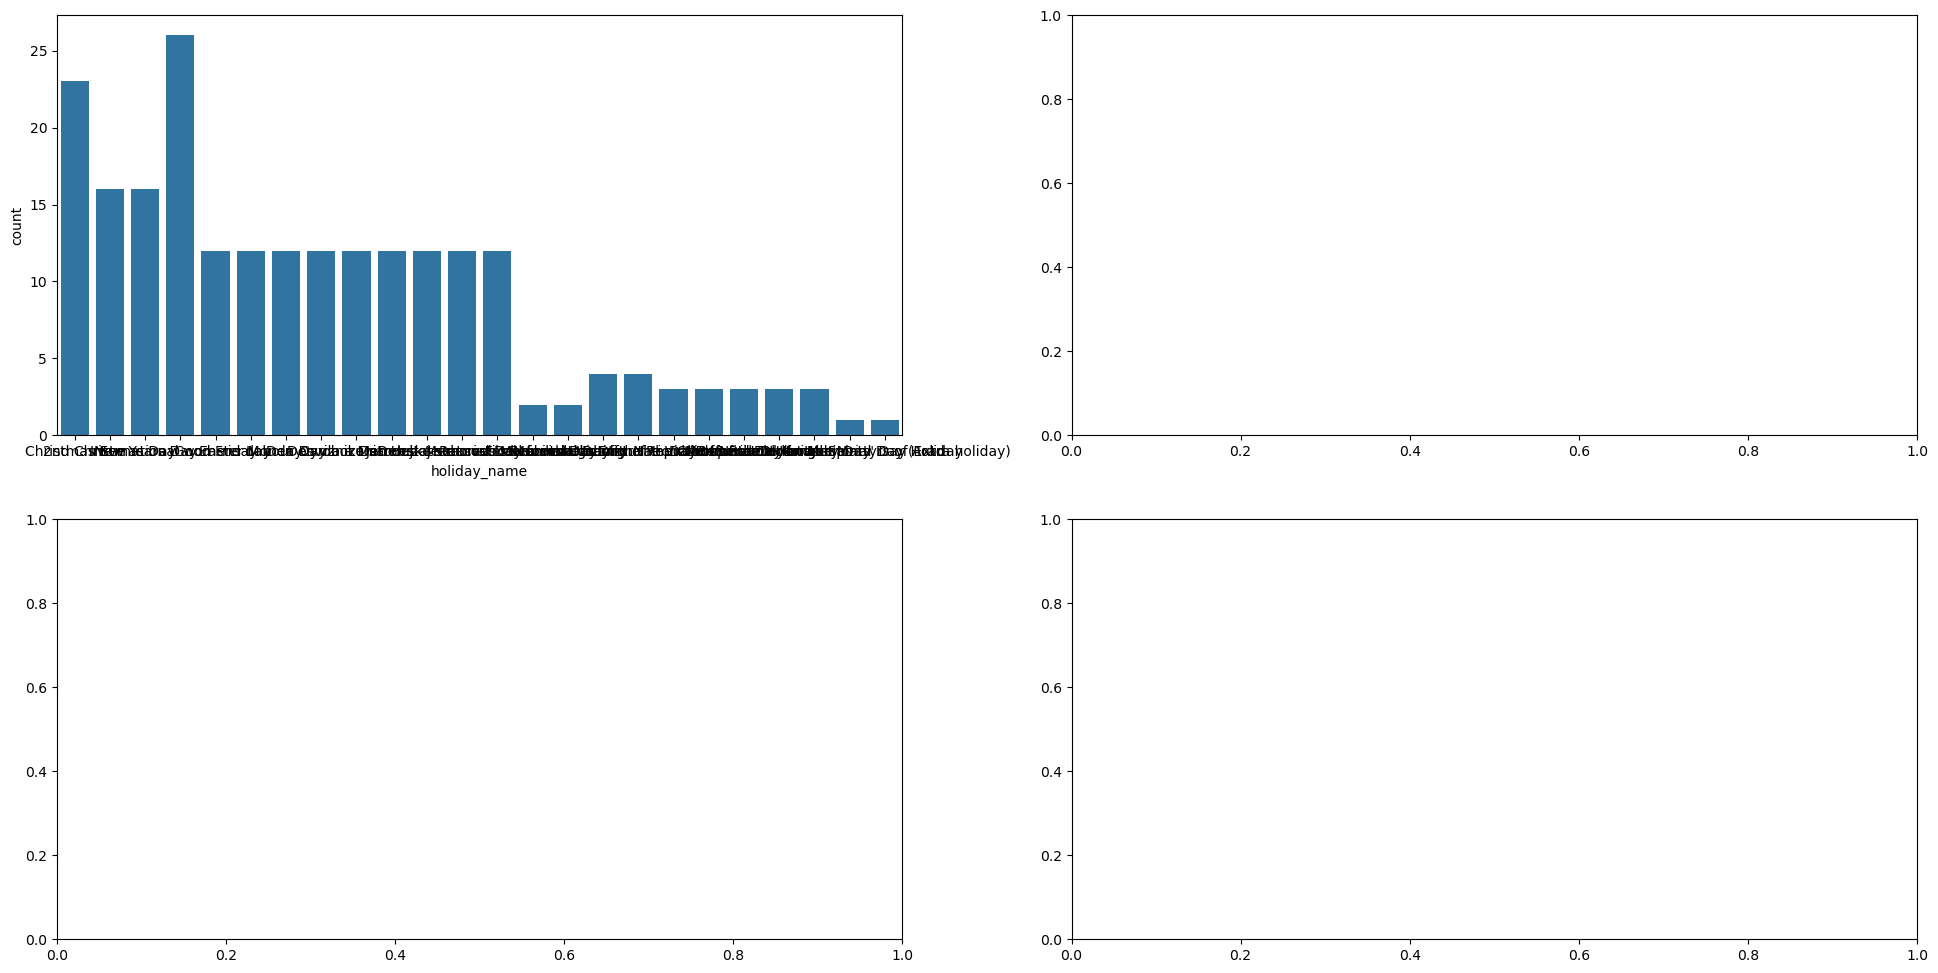

In [7]:
def plot_data(metadata):
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))
    sns.countplot(data=metadata, x="holiday_name", ax=axes[0][0])

plot_data(metadata=train)

In [8]:
train.isna()["holiday_name"].sum()

7122

In [9]:

# use same mappings for both train and inference
#use cat boost, ada boost, xgboost, lgbm

holiday_map = {k: v-1 for v, k in enumerate(train["holiday_name"].unique())}
for key in holiday_map:
    if isinstance(key, float) and np.isnan(key):
        holiday_map[-1] = holiday_map.pop(key)
        break

warehouse_map = {k: v for v, k in enumerate(train["warehouse"].unique())}


In [21]:
class Ensembler:
    def __init__(self, train_metadata, test_metadata, search):
        self.models_info = {
            "models": [None, None, None, None, None],
            "models_acc": [0, 0, 0, 0, 0],
            "models_mae": [999, 999, 999, 999, 999],
            "ensembler_acc": []
        }

        self.name_to_idx = {k: v for v, k in enumerate(["xgb", "cat", "lightgbm", "ada", "forest"])}
        self.idx_to_name = {v: k for k, v in self.name_to_idx.items()}

        self.scaler = StandardScaler()

        self.cleared_train_data = self.clear_data(metadata=train_metadata, test_metadata=test_metadata)
        self.cleared_test_data = self.clear_data(metadata=test_metadata, test_metadata=test_metadata, test=True)

        self.train_dataset, self.eval_dataset = train_test_split(self.cleared_train_data, test_size=0.2, shuffle=True, random_state=1343)
        self.search = search

        self.ensemble = None
        self.ensemble_acc = 0

    def clear_data(self, metadata, test_metadata, test: bool = False):
        new_df = metadata.copy()
        common_columns = new_df.columns.intersection(test_metadata.columns)
        if not test:
            uncommon_columns = new_df.drop(columns=common_columns).columns[1:] # keep orders
        else:
            uncommon_columns = new_df.drop(columns=common_columns).columns


        new_df = new_df.drop(columns=uncommon_columns)
        new_df = new_df.drop(columns=["id"])
        new_df.fillna({"holiday_name": -1}, inplace=True)
        new_df["holiday_name"] = new_df["holiday_name"].map(holiday_map)
        #new_df["holiday_name"] = new_df["holiday_name"].map(holiday_map)
        new_df["warehouse"] = new_df["warehouse"].map(warehouse_map)
        #new_df["warehouse"] = new_df["warehouse"].map(warehouse_map)

        #week_day = new_df["date"].dt.dayofweek
        new_df["date"] = pd.to_datetime(new_df["date"])
        #new_df["day_of_week"] = new_df["date"].dt.dayofweek
        new_df["day_of_week_sin"] = np.sin(2 * np.pi * new_df["date"].dt.dayofweek / 7)
        new_df["day_of_week_cos"] = np.cos(2 * np.pi * new_df["date"].dt.dayofweek / 7)

        #new_df["day_of_year"] = new_df["date"].dt.dayofyear
        new_df["day_of_year_sin"] = np.sin(2 * np.pi * new_df["date"].dt.dayofyear / 365)
        new_df["day_of_year_cos"] = np.cos(2 * np.pi * new_df["date"].dt.dayofyear / 365)

        #new_df["day_of_month"] = new_df["date"].dt.day
        new_df["day_of_month_sin"] = np.sin(2 * np.pi * new_df["date"].dt.day / 30)
        new_df["day_of_month_cos"] = np.cos(2 * np.pi * new_df["date"].dt.day / 30)
        
        #new_df["month"] = new_df["date"].dt.month
        new_df["month_sin"] = np.sin(2 * np.pi * new_df["date"].dt.month / 12)
        new_df["month_cos"] = np.cos(2 * np.pi * new_df["date"].dt.month / 12)
        
        #new_df["year"] = new_df["date"].dt.year
        new_df["year_sin"] = np.sin(2 * np.pi * new_df["date"].dt.year / 2024)
        new_df["year_cos"] = np.cos(2 * np.pi * new_df["date"].dt.year / 2024)

        new_df.drop(columns=["date"], inplace=True)
        return new_df

    def __getitem__(self, name: str):
        return (self.models_info["models"][self.name_to_idx[name]], self.models_info["models_acc"][self.name_to_idx[name]])


    def model_tuner(self, n_tries, model_type: str):
        models = []
        models_acc = []
        models_mae = []
        
        match model_type:
            case "xgb":
                params = {
                    "n_estimators": [200, 400, 600],
                    #"n_estimators": [100, 200],
                    "learning_rate": [0.001, 0.1, 0.8, 0.3, 0.5],
                    #"learning_rate": [0.001, 0.1, 0.3],
                    "max_depth": [4, 6, 9, 10, 16],
                    #"max_depth": [6, 9],
                    "lambda": [6, 8, 16],
                    #"lambda": [6, 8],
                    "gamma": [2, 3, 4, 5, 10]
                    #"gamma": [2, 3]
                }
          
                random_states = [random.randint(0, 10000000) for _ in range(n_tries*2)]
            case "cat":
                params = {
                    #"iterations": [100, 500, 1000, 1500, 2000],
                    "n_estimators": [400, 600, 1000, 2000],
                    "learning_rate": [0.1, 0.3, 0.5, 0.05],
                    "max_depth": [6, 9, 10, 16],
                }
                random_states = [random.randint(0, 10000000) for _ in range(n_tries)]
            case "lightgbm":
                params = {
                    #"iterations": [100, 500, 1000, 1500, 2000],
                    "n_estimators": [400, 600, 1000, 2000],
                    "learning_rate": [0.1, 0.3, 0.5, 0.05],
                    "max_depth": [6, 9, 10, 16],
                }
                random_states = [random.randint(0, 10000000) for _ in range(n_tries)]
            case "ada":
                params = {
                    #"iterations": [100, 500, 1000, 1500, 2000],
                    "n_estimators": [400, 600, 1000, 2000],
                    "learning_rate": [0.1, 0.3, 0.5, 0.05],
                }
                random_states = [random.randint(0, 10000000) for _ in range(n_tries)]

            case "forest":
                params = {
                    "n_estimators": [400, 600, 1000, 2000],
                    "max_depth": [6, 9, 10, 16],
                }
                random_states = [random.randint(0, 10000000) for _ in range(n_tries)]




        for random_state in tqdm(random_states):
            #self.train_dataset, self.eval_dataset = train_test_split(self.cleared_train_data, test_size=0.1, shuffle=True)
            match model_type:
                case "xgb":
                    print(random_state)
                    #print(self.train_dataset.drop(columns=["orders"]).columns)
                    model = xgb.XGBRegressor(random_state=random_state)
                    model.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    #search = GridSearchCV(estimator=model, param_grid=params, verbose=2, cv=5)
                    search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=1, verbose=2, cv=5) # n_jobs=-1 uses all cores
                    search.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    
                    #acc = search.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
                    #preds = search.predict(self.eval_dataset.drop(columns=["orders"]))
                    #print(f"{model_type} got {acc} after random cv")
                    #print(f"{model_type} got MAE {mean_absolute_percentage_error(preds, self.eval_dataset['orders'])}")

                    model = search.best_estimator_
                case "cat":
                    model = cat.CatBoostRegressor(random_state=random_state, task_type="GPU", devices="0")
                    model.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    acc = model.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
                    print(f"{model_type} got {acc} starting acc")
                    search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=1, verbose=2, cv=5) # n_jobs=-1 uses all cores
                    search.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])

                    model = search.best_estimator_

                case "lightgbm":
                    model = lgb.LGBMRegressor(random_state=random_state)
                    model.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    acc = model.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
                    #search = GridSearchCV(estimator=model, param_grid=params, verbose=2, cv=5)
                    search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=1, verbose=2, cv=5) # n_jobs=-1 uses all cores
                    search.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    
                    model = search.best_estimator_

                case "ada":
                    model = AdaBoostRegressor(random_state=random_state)
                    model.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    acc = model.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
                    #search = GridSearchCV(estimator=model, param_grid=params, verbose=2, cv=5)
                    search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=1, verbose=2, cv=5) # n_jobs=-1 uses all cores
                    search.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])

                case "forest":
                    model = RandomForestRegressor(random_state=random_state)
                    model.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
                    acc = model.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
                    #search = GridSearchCV(estimator=model, param_grid=params, verbose=2, cv=5)
                    search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=1, verbose=2, cv=5) # n_jobs=-1 uses all cores
                    search.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
     
               
     
                    
 
            models.append(model)

            acc = model.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
            preds = model.predict(self.eval_dataset.drop(columns=["orders"]))
            print(f"{model_type} got {acc}")

            model_mae = mean_absolute_percentage_error(preds, self.eval_dataset['orders'])
            print(f"{model_type} got {model_mae}")

            models_acc.append(acc)
            models_mae.append(model_mae)
        
            #best_model = models[models_acc.index(max(models_acc))]
            best_model = models[models_mae.index(min(models_mae))]
            if min(models_mae) < self.models_info["models_mae"][self.name_to_idx[model_type]]:
                print(f"{min(models_mae)} smaller than last mae {self.models_info['models_mae'][self.name_to_idx[model_type]]}")
                self.models_info["models"][self.name_to_idx[model_type]] = best_model
                #self.models_info["models_acc"][self.name_to_idx[model_type]] = (max(models_acc))
                self.models_info["models_mae"][self.name_to_idx[model_type]] = (min(models_mae))

            else:
                print(f"{min(models_mae)} bigger than {self.models_info['models_mae'][self.name_to_idx[model_type]]}")
            print(f"eval dataset got {len(self.eval_dataset.drop(columns=['orders']).columns)} columns")

    def train_models(self, n_tries):
        model_types = ["forest", "ada", "lightgbm", "xgb", "cat"]
        for model_type in model_types:
            self.model_tuner(n_tries=n_tries, model_type=model_type)

    def make_ensemble(self, n_tries=100):
        self.train_models(n_tries=n_tries)
        inverted_mapes = [1 / mape for mape in self.models_info["models_mae"]]
        weights = [w / sum(inverted_mapes) for w in inverted_mapes]
        self.ensemble = VotingRegressor(
            estimators=[
                (self.idx_to_name[idx], model) 
                for idx, model in enumerate(self.models_info["models"]) 
                if model is not None
                ],
                weights=weights
            )
        #self.ensemble = VotingRegressor(estimators=[("xgb", self.models_info["models"][0]), ("cat", self.models_info["models"][1])])
        #print([(self.idx_to_name[idx], model) for idx, model in enumerate(self.models_info["models"]) if model is not None])

    def fit_ensemble(self):
        self.ensemble.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
        self.ensemble_acc = self.ensemble.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
        preds = self.ensemble.predict(self.eval_dataset.drop(columns=["orders"]))
        print(f"Got acc of {self.ensemble_acc}")
        print(f"Got MAE percentage of {mean_absolute_percentage_error(preds, self.eval_dataset['orders'])}")


 
        

In [22]:
#models = generate_model(n_models=1000)
test_metadata = pd.read_csv(test_path)
train_metadata = pd.read_csv(train_path)
ensembler = Ensembler(train_metadata=train_metadata, test_metadata=test_metadata, search=None)
print(len(ensembler.cleared_train_data.drop(columns=['orders']).columns))
print(len(ensembler.cleared_test_data.columns))
ensembler.cleared_train_data.head()

16
16


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,year_sin,year_cos
0,0,6895.0,-1,0,0,0,0,-0.974928,-0.222521,-0.417194,0.908818,0.866025,0.500000,-2.449294e-16,1.0,-0.012417,0.999923
1,0,6584.0,-1,0,0,0,0,-0.781831,0.623490,-0.401488,0.915864,0.951057,0.309017,-2.449294e-16,1.0,-0.012417,0.999923
2,0,7030.0,-1,0,0,0,0,0.000000,1.000000,-0.385663,0.922640,0.994522,0.104528,-2.449294e-16,1.0,-0.012417,0.999923
3,0,6550.0,-1,0,0,0,0,0.781831,0.623490,-0.369725,0.929141,0.994522,-0.104528,-2.449294e-16,1.0,-0.012417,0.999923
4,0,6910.0,-1,0,0,0,0,0.974928,-0.222521,-0.353676,0.935368,0.951057,-0.309017,-2.449294e-16,1.0,-0.012417,0.999923


In [23]:
#ensembler.model_finder(n_tries=10, model_type="cat")
#ensembler.train_models(n_tries=10)
ensembler.make_ensemble(n_tries=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....................max_depth=10, n_estimators=600; total time=   7.8s
[CV] END .....................max_depth=10, n_estimators=600; total time=   7.7s
[CV] END .....................max_depth=10, n_estimators=600; total time=   7.8s
[CV] END .....................max_depth=10, n_estimators=600; total time=   7.8s
[CV] END .....................max_depth=10, n_estimators=600; total time=   7.8s
forest got 0.959523525972816
forest got 0.043845220555788406
0.043845220555788406 smaller than last mae 999
eval dataset got 16 columns


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ................learning_rate=0.5, n_estimators=400; total time=   2.1s
[CV] END ................learning_rate=0.5, n_estimators=400; total time=   2.1s
[CV] END ................learning_rate=0.5, n_estimators=400; total time=   2.1s
[CV] END ................learning_rate=0.5, n_estimators=400; total time=   2.2s
[CV] END ................learning_rate=0.5, n_estimators=400; total time=   2.2s
ada got 0.8392501150623566
ada got 0.1364864468060178
0.1364864468060178 smaller than last mae 999
eval dataset got 16 columns


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 16
[LightGBM] [Info] Start training from score 5507.826975
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 4697, number of used features: 16
[LightGBM] [Info] Start training from score 5500.887588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

  0%|          | 0/2 [00:00<?, ?it/s]

7922255
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gamma=3, lambda=6, learning_rate=0.3, max_depth=16, n_estimators=200; total time=   1.2s
[CV] END gamma=3, lambda=6, learning_rate=0.3, max_depth=16, n_estimators=200; total time=   1.2s
[CV] END gamma=3, lambda=6, learning_rate=0.3, max_depth=16, n_estimators=200; total time=   1.4s
[CV] END gamma=3, lambda=6, learning_rate=0.3, max_depth=16, n_estimators=200; total time=   1.1s
[CV] END gamma=3, lambda=6, learning_rate=0.3, max_depth=16, n_estimators=200; total time=   1.0s
xgb got 0.9726754612203617
xgb got 0.03945774746519163
0.03945774746519163 smaller than last mae 999
eval dataset got 16 columns
1198815
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gamma=3, lambda=8, learning_rate=0.5, max_depth=6, n_estimators=600; total time=   0.6s
[CV] END gamma=3, lambda=8, learning_rate=0.5, max_depth=6, n_estimators=600; total time=   1.0s
[CV] END gamma=3, lambda=8, learning_rate=0.5, max_de

  0%|          | 0/1 [00:00<?, ?it/s]

Learning rate set to 0.050936
0:	learn: 2077.4154557	total: 6.43ms	remaining: 6.43s
1:	learn: 1989.9737788	total: 12.5ms	remaining: 6.24s
2:	learn: 1905.9134479	total: 24.3ms	remaining: 8.08s
3:	learn: 1829.6182893	total: 31.5ms	remaining: 7.85s
4:	learn: 1757.9023417	total: 46.8ms	remaining: 9.32s
5:	learn: 1687.4418799	total: 54.2ms	remaining: 8.98s
6:	learn: 1618.7686106	total: 73.9ms	remaining: 10.5s
7:	learn: 1554.2134838	total: 93ms	remaining: 11.5s
8:	learn: 1494.7829930	total: 99.6ms	remaining: 11s
9:	learn: 1440.7240081	total: 106ms	remaining: 10.5s
10:	learn: 1390.5213105	total: 113ms	remaining: 10.1s
11:	learn: 1339.6239254	total: 118ms	remaining: 9.73s
12:	learn: 1291.4569007	total: 124ms	remaining: 9.39s
13:	learn: 1247.5000046	total: 130ms	remaining: 9.14s
14:	learn: 1205.5105446	total: 135ms	remaining: 8.88s
15:	learn: 1166.3665933	total: 141ms	remaining: 8.66s
16:	learn: 1132.0951424	total: 147ms	remaining: 8.5s
17:	learn: 1097.4987664	total: 152ms	remaining: 8.32s
18:	

In [24]:
ensembler["xgb"][0].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 3,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 600,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 1198815,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'lambda': 8}

In [25]:
ensembler.fit_ensemble()

0:	learn: 1991.9508436	total: 6.15ms	remaining: 3.68s
1:	learn: 1830.2654473	total: 12.2ms	remaining: 3.65s
2:	learn: 1683.9951976	total: 17.9ms	remaining: 3.56s
3:	learn: 1557.9487107	total: 23.5ms	remaining: 3.5s
4:	learn: 1441.9327024	total: 29.6ms	remaining: 3.52s
5:	learn: 1336.9438491	total: 35.2ms	remaining: 3.48s
6:	learn: 1242.9257564	total: 40.7ms	remaining: 3.45s
7:	learn: 1162.7840686	total: 46.8ms	remaining: 3.46s
8:	learn: 1093.1729485	total: 52.5ms	remaining: 3.45s
9:	learn: 1029.0849140	total: 58.1ms	remaining: 3.43s
10:	learn: 987.4550892	total: 64.2ms	remaining: 3.44s
11:	learn: 936.3715697	total: 69.8ms	remaining: 3.42s
12:	learn: 891.7127872	total: 75.4ms	remaining: 3.41s
13:	learn: 855.8034866	total: 81.6ms	remaining: 3.42s
14:	learn: 822.4196904	total: 87.3ms	remaining: 3.4s
15:	learn: 792.2142666	total: 93.2ms	remaining: 3.4s
16:	learn: 766.0160854	total: 99.1ms	remaining: 3.4s
17:	learn: 741.8455813	total: 105ms	remaining: 3.39s
18:	learn: 721.2358754	total: 111

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 9990,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [26]:

print(ensembler.models_info)
#preds = ensembler.ensemble.predict(ensemble.cleared_test_data)
preds = ensembler.ensemble.predict(ensembler.cleared_test_data).astype(np.int64)
#preds = ensembler["cat"][0].predict(ensembler.cleared_test_data).astype(np.int64)
print(len(ensembler.cleared_test_data.columns))
print(preds)
ensembler.cleared_test_data.head(5)

{'models': [XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=8, learning_rate=0.5,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, ...), <catboost.core.CatBoostRegressor object at 0x7f466e358250>, LGBMRegressor(learning_rate=0.5, max_depth=9, n_estimators=400,
              random_state=1347447), AdaBoostRegressor(random_state=9825363), RandomForestRegressor(random_state=7585727)], 'models_a

,warehouse,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,year_sin,year_cos
0,0,-1,0,0,0,0,-0.974928,-0.222521,0.965740,0.259512,-0.207912,-0.978148,1.0,6.123234e-17,-2.449294e-16,1.0
1,0,-1,0,0,0,0,-0.781831,0.623490,0.970064,0.242850,-0.406737,-0.913545,1.0,6.123234e-17,-2.449294e-16,1.0
2,0,-1,0,0,0,0,0.000000,1.000000,0.974100,0.226116,-0.587785,-0.809017,1.0,6.123234e-17,-2.449294e-16,1.0
3,0,-1,0,0,0,0,0.781831,0.623490,0.977848,0.209315,-0.743145,-0.669131,1.0,6.123234e-17,-2.449294e-16,1.0
4,0,-1,0,0,0,0,0.974928,-0.222521,0.981306,0.192452,-0.866025,-0.500000,1.0,6.123234e-17,-2.449294e-16,1.0


In [27]:
test_metadata = pd.read_csv(test_path)
df = {
    "id": test_metadata["id"],
    "orders": preds
}

df = pd.DataFrame(df)
df.to_csv("./submission.csv", index=False)
df.head(100)

,id,orders
0,Prague_1_2024-03-16,10167
1,Prague_1_2024-03-17,10102
2,Prague_1_2024-03-18,9785
3,Prague_1_2024-03-19,9602
4,Prague_1_2024-03-20,9370
...,...,...
95,Brno_1_2024-04-19,9927
96,Brno_1_2024-04-20,8728
97,Brno_1_2024-04-21,8097
98,Brno_1_2024-04-22,8044
